#  Project Time Series Using No2

#  Dataset From Copernicus

In [1]:
import openeo
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import xarray as xr

connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()
print("Connected to Copernicus Data Space Ecosystem")

Authenticated using refresh token.
Connected to Copernicus Data Space Ecosystem


In [2]:
aoi = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              112.73774939039936,
              -7.024663796917935
            ],
            [
              112.73774939039936,
              -7.040536128904094
            ],
            [
              112.75534132424036,
              -7.040536128904094
            ],
            [
              112.75534132424036,
              -7.024663796917935
            ],
            [
              112.73774939039936,
              -7.024663796917935
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}

# 3. Definisi Batas Spasial (Spatial Extent) - Baru
spatial_extent = {
    "west": 112.73774939039936,
    "south": -7.040536128904094,
    "east": 112.75534132424036,
    "north": -7.024663796917935
}


# 4. Definisi Waktu
start_date = "2021-01-01"
end_date = "2025-10-19" 

print(f"AOI defined for coordinates: {spatial_extent}")
print(f"Time range: {start_date} to {end_date}")
print("Setup completed successfully")

AOI defined for coordinates: {'west': 112.73774939039936, 'south': -7.040536128904094, 'east': 112.75534132424036, 'north': -7.024663796917935}
Time range: 2021-01-01 to 2025-10-19
Setup completed successfully


In [3]:
print("Loading Sentinel-5P NO2 data...")

s5p_no2 = connection.load_collection(
    "SENTINEL_5P_L2",
    temporal_extent=[start_date, end_date],
    spatial_extent=spatial_extent,
    bands=["NO2"],
)

s5p_monthly = s5p_no2.aggregate_temporal_period(
    period="day",
    reducer="mean"
)

print("Data collection and aggregation configured successfully")

Loading Sentinel-5P NO2 data...


Data collection and aggregation configured successfully


In [4]:
print("Starting data processing job...")

job = s5p_monthly.execute_batch(
    title="NO2 Averages 2021-2025", 
    outputfile="no2_averages_4years.nc"
)


Starting data processing job...


0:00:00 Job 'j-2510250313214440be94abf599f3fbc8': send 'start'


0:00:13 Job 'j-2510250313214440be94abf599f3fbc8': created (progress 0%)


0:00:19 Job 'j-2510250313214440be94abf599f3fbc8': created (progress 0%)


0:00:26 Job 'j-2510250313214440be94abf599f3fbc8': created (progress 0%)


# missing value dengan interpolasi

Data mentah kita (no2_output.csv) memiliki missing values yang ditandai sebagai "--".

Cell ini akan memuat data, memberi tahu pandas bahwa "--" adalah NaN (data hilang), lalu mengisi semua NaN tersebut menggunakan interpolasi linear. Kita juga membuat plot perbandingan untuk membuktikan bahwa data yang bolong (merah) telah terisi (biru).

--- Memulai Tugas No. 2: Cek, Interpolasi & Visualisasi ---
Membaca file: no2_output.csv...
File berhasil dimuat oleh Pandas (dengan deteksi '--' sebagai NaN).

--- Mengecek missing values (SEBELUM interpolasi) ---

Jumlah Missing Values per Kolom (Setelah deteksi '--'):
Time                0
Latitude (y)        0
Longitude (x)       0
NO2              1043
NO2_Asli         1043
dtype: int64

BERHASIL DITEMUKAN: 1043 missing values di 'NO2'.
Memulai proses interpolasi...
Mengurutkan data berdasarkan lokasi (y, x) dan waktu (t)...
Melakukan interpolasi linear...
Interpolasi selesai.
Missing values di 'NO2' SETELAH interpolasi: 0

Menyimpan data bersih ke no2_interpolated.csv...
File disimpan sebagai: no2_interpolated.csv

Membuat plot perbandingan...
Menampilkan plot untuk lokasi: Lat -7.023175017792986, Lon 112.7650311364311


C:\Users\FIKRI\AppData\Local\Temp\ipykernel_19548\1538664454.py:59: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['NO2'] = df['NO2'].fillna(method='ffill').fillna(method='bfill')
C:\Users\FIKRI\AppData\Local\Temp\ipykernel_19548\1538664454.py:124: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  plt.tight_layout()
c:\Users\FIKRI\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


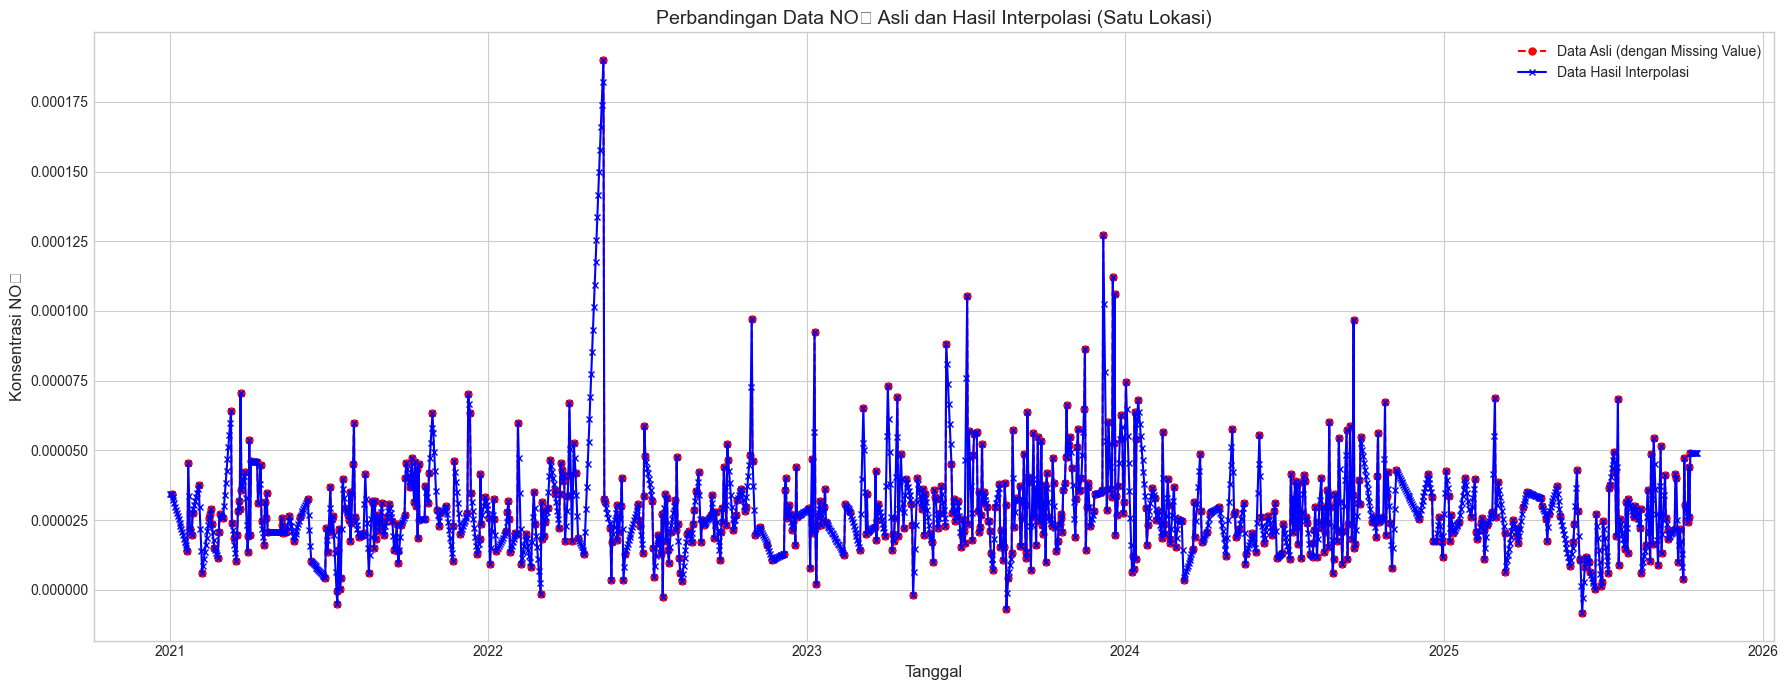

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # Import library untuk plotting
import sys

# --- 1. Pengaturan File ---
input_csv = 'no2_output.csv'        # File input dari Langkah 1
output_csv = 'no2_interpolated.csv' # File output bersih untuk Langkah 3

print(f"--- Memulai Tugas No. 2: Cek, Interpolasi & Visualisasi ---")
print(f"Membaca file: {input_csv}...")

try:
    # --- 2. Muat CSV ---
    # Kita tambahkan na_values='--' untuk membaca "--" sebagai NaN
    df = pd.read_csv(
        input_csv, 
        parse_dates=['Time'], 
        na_values='--'  # Ini adalah kunci untuk mendeteksi missing value Anda
    )
    print("File berhasil dimuat oleh Pandas (dengan deteksi '--' sebagai NaN).")

    # --- 3. Simpan Data Asli untuk Plotting ---
    # Kita buat salinan kolom NO2 (yang masih bolong) sebelum diinterpolasi
    # Ini akan menjadi data 'Data Asli' (titik merah) di plot
    df['NO2_Asli'] = df['NO2'].copy()

    # --- 4. Cek Missing Values ---
    print("\n--- Mengecek missing values (SEBELUM interpolasi) ---")
    print("\nJumlah Missing Values per Kolom (Setelah deteksi '--'):")
    missing_info = df.isnull().sum()
    print(missing_info)
    
    total_missing_no2 = df['NO2'].isnull().sum()
    
    if total_missing_no2 == 0:
        # --- 5a. JIKA TIDAK ADA DATA HILANG ---
        print("\nTidak ada missing values di 'NO2'.")
        # Hapus kolom bantu 'NO2_Asli' sebelum menyimpan
        df = df.drop(columns=['NO2_Asli'])
        df.to_csv(output_csv, index=False)
        
    else:
        # --- 5b. JIKA ADA DATA HILANG (PROSES INTERPOLASI) ---
        print(f"\nBERHASIL DITEMUKAN: {total_missing_no2} missing values di 'NO2'.")
        print("Memulai proses interpolasi...")
        
        # Urutkan data berdasarkan lokasi (y, x) dan waktu (t)
        # Ini PENTING agar interpolasi bekerja dengan benar
        print("Mengurutkan data berdasarkan lokasi (y, x) dan waktu (t)...")
        df = df.sort_values(by=['Latitude (y)', 'Longitude (x)', 'Time'])
        
        # Lakukan interpolasi linear pada kolom 'NO2'
        # Kolom 'NO2_Asli' tidak akan tersentuh
        print("Melakukan interpolasi linear...")
        df['NO2'] = df['NO2'].interpolate(method='linear')
        
        # Sapu bersih (untuk NaN di baris paling awal/akhir)
        df['NO2'] = df['NO2'].fillna(method='ffill').fillna(method='bfill')
        print("Interpolasi selesai.")

        # Verifikasi
        final_missing_count = df['NO2'].isnull().sum()
        print(f"Missing values di 'NO2' SETELAH interpolasi: {final_missing_count}")

        # --- 6. Simpan File CSV (Output Utama) ---
        # Kita simpan file bersih TANPA kolom 'NO2_Asli'
        print(f"\nMenyimpan data bersih ke {output_csv}...")
        df.drop(columns=['NO2_Asli']).to_csv(output_csv, index=False)

    print(f"File disimpan sebagai: {output_csv}")

    # --- 7. TAMBAHAN: VISUALISASI ---
    print("\nMembuat plot perbandingan...")
    
    # Pilih SATU lokasi untuk di-plot (kita ambil lokasi pertama)
    first_lat = df['Latitude (y)'].iloc[0]
    first_lon = df['Longitude (x)'].iloc[0]
    
    print(f"Menampilkan plot untuk lokasi: Lat {first_lat}, Lon {first_lon}")
    
    # Filter dataframe agar hanya berisi data dari lokasi pertama
    df_plot = df.loc[
        (df['Latitude (y)'] == first_lat) & 
        (df['Longitude (x)'] == first_lon)
    ].copy()

    # Atur style plot agar mirip (seaborn-whitegrid)
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Buat kanvas plot yang lebar
    plt.figure(figsize=(18, 7))
    
    # 1. Plot Data Asli (Merah, titik-titik, garis putus-putus)
    plt.plot(
        df_plot['Time'], 
        df_plot['NO2_Asli'],  # <-- Data asli yang bolong
        marker='o', 
        markersize=5,
        markerfacecolor='red',
        linestyle='--', 
        color='red', 
        label='Data Asli (dengan Missing Value)'
    )
    
    # 2. Plot Data Interpolasi (Biru, 'x', garis solid)
    plt.plot(
        df_plot['Time'], 
        df_plot['NO2'],       # <-- Data yang sudah diinterpolasi
        marker='x', 
        markersize=5,
        linestyle='-', 
        color='blue', 
        label='Data Hasil Interpolasi'
    )
    
    # Judul dan Label
    plt.title('Perbandingan Data NO₂ Asli dan Hasil Interpolasi (Satu Lokasi)', fontsize=14)
    plt.xlabel('Tanggal', fontsize=12)
    plt.ylabel('Konsentrasi NO₂', fontsize=12)
    plt.legend()
    
    # Tampilkan plot
    plt.tight_layout()
    plt.show()


except FileNotFoundError:
    print(f"Error: File '{input_csv}' tidak ditemukan.", file=sys.stderr)
except Exception as e:
    print(f"Terjadi error: {e}", file=sys.stderr)

# Supervised

di sini kita gunakan 4 fitur atau 4 hari sebelumnya untuk memprediksi No2 di hari ini

In [3]:
import pandas as pd
import numpy as np
import sys

# --- 1. Pengaturan ---
input_csv = 'no2_interpolated.csv'      
output_csv = 'no2_supervised_4lags.csv' 
N_LAGS = 4 

# --- 2. Fungsi dari Referensi (series_to_supervised) ---
# Fungsi ini akan kita panggil berulang kali untuk setiap lokasi
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Mengubah time series menjadi dataset supervised.
    n_in: Jumlah observasi lampau (X).
    n_out: Jumlah observasi masa depan (y).
    """
    # Pastikan data adalah DataFrame
    if isinstance(data, pd.Series):
        data = data.to_frame()
        
    n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # Gabungkan semua
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # Hapus baris dengan nilai NaN (yang muncul akibat shifting)
    if dropnan:
        agg.dropna(inplace=True)
    return agg

print(f"--- Memulai Tugas No. 3: Membentuk Data Supervised (Lag={N_LAGS}) ---")

try:
    # --- 3. Muat Data Bersih ---
    df = pd.read_csv(input_csv, parse_dates=['Time'])
    print(f"File '{input_csv}' berhasil dimuat.")
    
    # --- 4. Proses Lagging per Lokasi ---
    all_locations_supervised = [] # List untuk menampung hasil
    
    # Kita kelompokkan data berdasarkan lokasi unik
    grouped_locations = df.groupby(['Latitude (y)', 'Longitude (x)'])
    
    print(f"Menemukan {len(grouped_locations)} lokasi unik.")
    print("Memproses lag untuk setiap lokasi...")

    for (lat, lon), group in grouped_locations:
        # Ambil hanya kolom data dan atur 'Time' sebagai index
        # (penting untuk time series)
        location_data = group.set_index('Time')[['NO2']]
        
        # Terapkan fungsi supervised
        supervised_df = series_to_supervised(location_data, N_LAGS, 1)
        
        # Tambahkan kembali info lokasi
        supervised_df['Latitude (y)'] = lat
        supervised_df['Longitude (x)'] = lon
        
        all_locations_supervised.append(supervised_df)

    print("Semua lokasi selesai diproses.")

    # --- 5. Gabungkan & Rapikan ---
    print("Menggabungkan semua hasil...")
    final_supervised_df = pd.concat(all_locations_supervised)

    # Ganti nama kolom agar sesuai dengan referensi
    column_renames = {
        'var1(t-4)': 'NO2(t-4)',
        'var1(t-3)': 'NO2(t-3)',
        'var1(t-2)': 'NO2(t-2)',
        'var1(t-1)': 'NO2(t-1)',
        'var1(t)': 'Target_NO2(t)'
    }
    final_supervised_df = final_supervised_df.rename(columns=column_renames)
    
    # Atur ulang urutan kolom
    cols_to_show = [
        'Latitude (y)', 'Longitude (x)', 
        'NO2(t-4)', 'NO2(t-3)', 'NO2(t-2)', 'NO2(t-1)', 
        'Target_NO2(t)'
    ]
    # Reset index (waktu) agar menjadi kolom biasa
    final_supervised_df = final_supervised_df.reset_index().rename(columns={'index':'Time'})
    final_supervised_df = final_supervised_df[ ['Time'] + cols_to_show ]

    # --- 6. Simpan & Tampilkan Hasil ---
    final_supervised_df.to_csv(output_csv, index=False)
    
    print(f"\nBERHASIL! Data supervised disimpan ke: {output_csv}")
    print("\n--- Tampilan 5 Baris Pertama Data Supervised ---")
    print(final_supervised_df.head())
    
    print("\nInfo Data Supervised:")
    final_supervised_df.info()

except FileNotFoundError:
    print(f"Error: File '{input_csv}' tidak ditemukan.", file=sys.stderr)
    print("Pastikan Anda sudah menjalankan skrip Tugas No. 2.", file=sys.stderr)
except Exception as e:
    print(f"Terjadi error: {e}", file=sys.stderr)

--- Memulai Tugas No. 3: Membentuk Data Supervised (Lag=4) ---
File 'no2_interpolated.csv' berhasil dimuat.
Menemukan 1 lokasi unik.
Memproses lag untuk setiap lokasi...
Semua lokasi selesai diproses.
Menggabungkan semua hasil...

BERHASIL! Data supervised disimpan ke: no2_supervised_4lags.csv

--- Tampilan 5 Baris Pertama Data Supervised ---
        Time  Latitude (y)  Longitude (x)  NO2(t-4)  NO2(t-3)  NO2(t-2)  \
0 2021-01-05     -7.023175     112.765031  0.000034  0.000034  0.000034   
1 2021-01-06     -7.023175     112.765031  0.000034  0.000034  0.000033   
2 2021-01-07     -7.023175     112.765031  0.000034  0.000033  0.000032   
3 2021-01-08     -7.023175     112.765031  0.000033  0.000032  0.000031   
4 2021-01-09     -7.023175     112.765031  0.000032  0.000031  0.000030   

   NO2(t-1)  Target_NO2(t)  
0  0.000033       0.000032  
1  0.000032       0.000031  
2  0.000031       0.000030  
3  0.000030       0.000029  
4  0.000029       0.000028  

Info Data Supervised:
<class 

# Memisahkan Data Testing dan Data Training

Kita membagi data menjadi dua bagian: 80% data awal sebagai data latih (training), yang berfungsi sebagai "materi belajar" untuk model. Sisa 20% data terakhir kita sisihkan sebagai data uji (testing), yang berfungsi sebagai "soal ujian". Tujuannya adalah untuk melatih model pada data "masa lalu" (latih) dan mengukur seberapa baik performanya dalam menebak data "masa depan" (uji) yang belum pernah ia lihat.

In [4]:


# --- 1. Pengaturan ---
input_csv = 'no2_supervised_4lags.csv' # File dari Tugas 3
TRAIN_PERCENT = 0.8 # 80% data untuk training, 20% untuk testing

print(f"--- Memisahkan Data ---")

try:
    # --- 2. Muat Data Supervised ---
    df = pd.read_csv(input_csv)

    # --- 3. Pisahkan Fitur (X) dan Target (y) ---
    features = ['NO2(t-4)', 'NO2(t-3)', 'NO2(t-2)', 'NO2(t-1)']
    target = 'Target_NO2(t)'
    
    X = df[features].values
    y = df[target].values
    
    # --- 4. Memisahkan Data (Training & Testing) ---
    train_size = int(len(X) * TRAIN_PERCENT)
    
    X_train, X_test = X[0:train_size], X[train_size:len(X)]
    y_train, y_test = y[0:train_size], y[train_size:len(y)]

    # --- OUTPUT SESUAI GAMBAR 1 ---
    print(f"Jumlah data training: {len(X_train)} baris")
    print(f"Jumlah data testing: {len(X_test)} baris")
    # -------------------------------

except FileNotFoundError:
    print(f"Error: File '{input_csv}' tidak ditemukan.", file=sys.stderr)
    print("Pastikan Anda sudah menjalankan skrip Tugas No. 3.", file=sys.stderr)
except Exception as e:
    print(f"Terjadi error: {e}", file=sys.stderr)

--- Memisahkan Data ---
Jumlah data training: 1388 baris
Jumlah data testing: 347 baris


## Normalisasi Data MIN-MAX

untuk memastikan keadilan dan akurasi pada model K-NN. Model K-NN bekerja berdasarkan "jarak", dan ia sangat sensitif terhadap skala data. Jika satu fitur (misal t-1) punya rentang nilai (0-100) dan fitur lain (misal t-2) punya rentang (0-0.1), model akan salah menganggap fitur t-1 jauh lebih penting. Tujuan normalisasi adalah untuk menyamakan skala semua fitur ke rentang yang sama (0 sampai 1), sehingga setiap fitur (t-1 s/d t-4) memberikan kontribusi yang adil dan setara dalam perhitungan jarak model.

In [5]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib # Library untuk menyimpan model/scaler
import sys

print(f"--- Memulai Cell 2: Normalisasi Min-Max (Tugas No. 4) ---")

try:
    # Cek apakah variabel dari Cell 1 sudah ada
    if 'X_train' not in locals():
        print("Error: Variabel 'X_train' tidak ditemukan.", file=sys.stderr)
        print("Harap jalankan Cell 1 terlebih dahulu.", file=sys.stderr)
        sys.exit()

    # --- 1. Logika Normalisasi (Tanpa print) ---
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_X = scaler_X.fit(X_train)
    X_train_scaled = scaler_X.transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    
    scaler_y = MinMaxScaler(feature_range=(0, 1))
    y_train_reshaped = y_train.reshape(-1, 1)
    y_test_reshaped = y_test.reshape(-1, 1)
    
    scaler_y = scaler_y.fit(y_train_reshaped)
    y_train_scaled = scaler_y.transform(y_train_reshaped)
    y_test_scaled = scaler_y.transform(y_test_reshaped)
    
    # --- 2. Simpan Hasil (Ini tetap penting untuk Tugas 5) ---
    joblib.dump(scaler_X, 'scaler_X.pkl')
    joblib.dump(scaler_y, 'scaler_y.pkl')
    np.save('X_train_scaled.npy', X_train_scaled)
    np.save('y_train_scaled.npy', y_train_scaled)
    np.save('X_test_scaled.npy', X_test_scaled)
    np.save('y_test_scaled.npy', y_test_scaled)
    
    # --- OUTPUT SESUAI GAMBAR 2 ---
    print("\n--- Contoh Data Setelah Normalisasi ---")
    print("X_train_scaled (5 baris pertama):")
    print(X_train_scaled[:5]) # Menampilkan 5 baris pertama X_train_scaled
    
    print("\ny_train_scaled (5 baris pertama):")
    print(y_train_scaled[:5]) # Menampilkan 5 baris pertama y_train_scaled
    
    print("\n Proses selesai. Data sekarang siap untuk dilatih menggunakan model machine learning.")
    # -------------------------------

except Exception as e:
    print(f"Terjadi error: {e}", file=sys.stderr)

--- Memulai Cell 2: Normalisasi Min-Max (Tugas No. 4) ---

--- Contoh Data Setelah Normalisasi ---
X_train_scaled (5 baris pertama):
[[0.20907321 0.20907321 0.20907321 0.20324057]
 [0.20907321 0.20907321 0.20324057 0.19740794]
 [0.20907321 0.20324057 0.19740794 0.19157531]
 [0.20324057 0.19740794 0.19157531 0.18574268]
 [0.19740794 0.19157531 0.18574268 0.17991005]]

y_train_scaled (5 baris pertama):
[[0.19740794]
 [0.19157531]
 [0.18574268]
 [0.17991005]
 [0.17407742]]

 Proses selesai. Data sekarang siap untuk dilatih menggunakan model machine learning.


# membangun model knn

Kita akan memuat data latih yang sudah dinormalisasi , lalu melatih model KNeighborsRegressor (kita gunakan k=14 ). Setelah model dilatih, kita akan mengujinya pada data uji. Tujuan utamanya adalah untuk mengevaluasi performa model dengan menghitung error (RMSE) dan R-squared (R²), serta melihat visual perbandingan antara nilai prediksi (merah) dan nilai aktual (biru).

--- Memulai Tugas No. 5: Membangun Model K-NN ---
Memuat data latih dan uji yang sudah dinormalisasi...
Data dan scaler berhasil dimuat.
Membangun model KNeighborsRegressor dengan k=14...
Model berhasil dilatih.
Membuat prediksi pada data uji...
Prediksi berhasil dikembalikan ke skala asli.

--- Hasil Evaluasi Model ---
Root Mean Squared Error (RMSE): 0.0000079911
R-squared (R²): 0.5330
Menampilkan plot perbandingan Aktual vs. Prediksi...


c:\Users\FIKRI\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


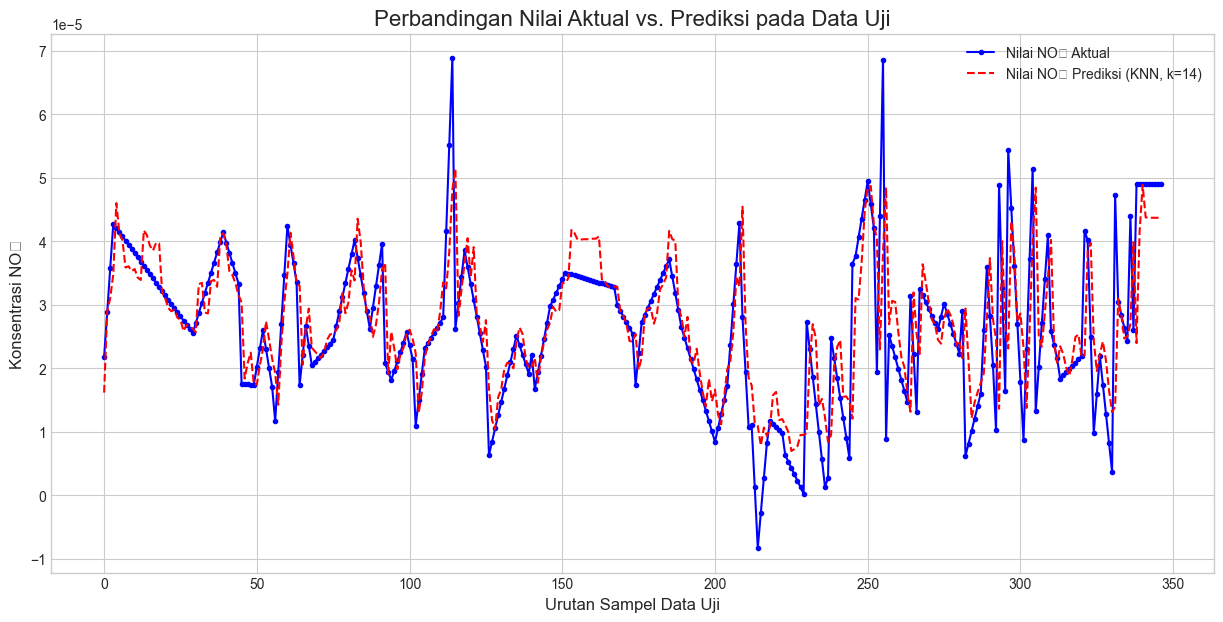

In [6]:
import numpy as np
import joblib # Untuk memuat scaler .pkl
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

print("--- Memulai Tugas No. 5: Membangun Model K-NN ---")

# --- 1. Pengaturan Nilai K ---
# Sesuai referensi, kita gunakan k=14 yang ditemukan optimal
k_value = 14

try:
    # --- 2. Muat Data yang Sudah Diproses (dari Tugas 4) ---
    print("Memuat data latih dan uji yang sudah dinormalisasi...")
    X_train_scaled = np.load('X_train_scaled.npy')
    y_train_scaled = np.load('y_train_scaled.npy')
    X_test_scaled = np.load('X_test_scaled.npy')
    y_test_scaled = np.load('y_test_scaled.npy')
    
    # Muat scaler (khususnya scaler_y untuk mengembalikan nilai prediksi)
    scaler_y = joblib.load('scaler_y.pkl')
    print("Data dan scaler berhasil dimuat.")

    # --- 3. Membangun & Melatih Model K-NN ---
    print(f"Membangun model KNeighborsRegressor dengan k={k_value}...")
    knn_model = KNeighborsRegressor(n_neighbors=k_value)
    
    # Melatih model
    # .ravel() mengubah y_train_scaled menjadi array 1D, sesuai yg diminta .fit()
    knn_model.fit(X_train_scaled, y_train_scaled.ravel())
    print("Model berhasil dilatih.")

    # --- 4. Membuat Prediksi ---
    print("Membuat prediksi pada data uji...")
    # Model memprediksi nilai yang masih ternormalisasi (0-1)
    y_pred_scaled = knn_model.predict(X_test_scaled)

    # --- 5. Mengembalikan Nilai ke Skala Asli (Inverse Transform) ---
    # Kita harus kembalikan ke skala asli (mol/m²) untuk evaluasi
    
    # Ubah prediksi (scaled) ke bentuk 2D, lalu inverse transform
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
    
    # Ubah data uji aktual (scaled) ke bentuk 2D, lalu inverse transform
    y_test_actual = scaler_y.inverse_transform(y_test_scaled)
    
    print("Prediksi berhasil dikembalikan ke skala asli.")

    # --- 6. Evaluasi Model ---
    mse = mean_squared_error(y_test_actual, y_pred)
    rmse = np.sqrt(mse) # Root Mean Squared Error
    r2 = r2_score(y_test_actual, y_pred) # R-squared

    print("\n--- Hasil Evaluasi Model ---")
    # :.10f artinya ambil 10 angka di belakang koma
    print(f"Root Mean Squared Error (RMSE): {rmse:.10f}")
    print(f"R-squared (R²): {r2:.4f}")

    # --- 7. Visualisasi Hasil Prediksi ---
    print("Menampilkan plot perbandingan Aktual vs. Prediksi...")
    plt.figure(figsize=(15, 7))
    plt.plot(y_test_actual, label='Nilai NO₂ Aktual', color='blue', marker='.', linestyle='-')
    plt.plot(y_pred, label=f'Nilai NO₂ Prediksi (KNN, k={k_value})', color='red', linestyle='--')

    plt.title('Perbandingan Nilai Aktual vs. Prediksi pada Data Uji', fontsize=16)
    plt.xlabel('Urutan Sampel Data Uji', fontsize=12)
    plt.ylabel('Konsentrasi NO₂', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

except FileNotFoundError:
    print("Error: File data (.npy) atau scaler (.pkl) tidak ditemukan.", file=sys.stderr)
    print("Pastikan Anda sudah menjalankan skrip Tugas No. 4.", file=sys.stderr)
except Exception as e:
    print(f"Terjadi error: {e}", file=sys.stderr)

## Nilai K Optimal

untuk menemukan nilai 'k' terbaik (paling optimal) untuk model kita. Di sini, kita akan menguji semua nilai 'k' dari 1 sampai 30. Tujuannya adalah membuat "Elbow Plot" yang menunjukkan error (RMSE) untuk setiap 'k', sehingga kita bisa secara objektif menentukan nilai 'k' mana yang memberikan error paling rendah.

--- Memulai Eksperimen: Mencari Nilai 'k' Optimal ---
Memulai loop untuk menguji k=1 hingga k=30...
Loop selesai.
Menampilkan plot 'Elbow Method' (RMSE vs. Nilai K)...


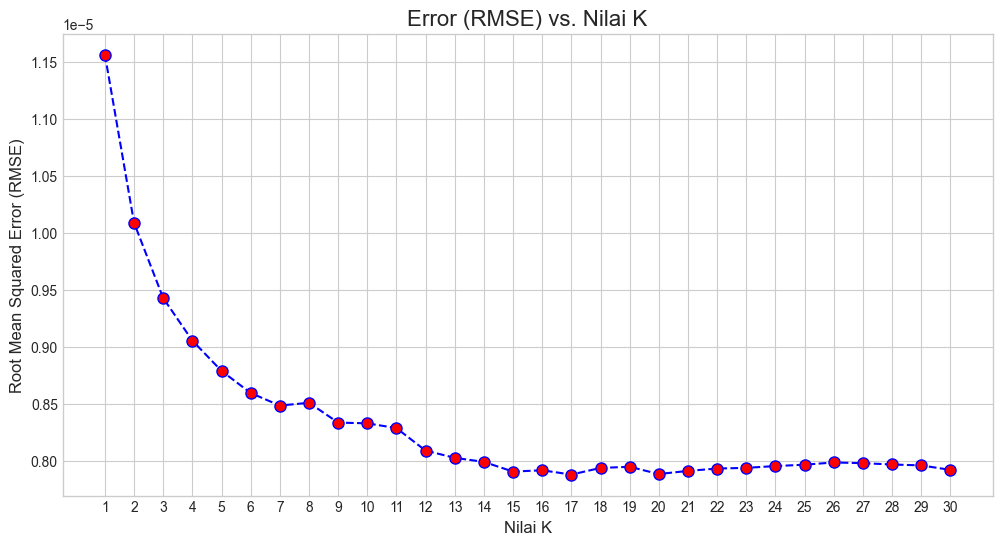


 Analisis Selesai:
   RMSE terendah adalah: 0.0000078798
   Nilai 'k' terbaik ditemukan pada: k = 17


In [7]:
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

print("--- Memulai Eksperimen: Mencari Nilai 'k' Optimal ---")

try:
    # --- 1. Pastikan data sudah dimuat ---
    # (Kode ini mengasumsikan variabel dari Cell 1 masih ada di memori)
    if 'X_train_scaled' not in locals():
        print("Memuat ulang data dari file...")
        X_train_scaled = np.load('X_train_scaled.npy')
        y_train_scaled = np.load('y_train_scaled.npy')
        X_test_scaled = np.load('X_test_scaled.npy')
        y_test_scaled = np.load('y_test_scaled.npy')
        scaler_y = joblib.load('scaler_y.pkl')
        # Siapkan y_test_actual sekali saja
        y_test_actual = scaler_y.inverse_transform(y_test_scaled)

    print("Memulai loop untuk menguji k=1 hingga k=30...")
    error_rates = [] # List untuk menyimpan nilai RMSE
    k_range = range(1, 31) # K yang akan kita uji

    for k in k_range:
        # 1. Buat & Latih model untuk setiap k
        model = KNeighborsRegressor(n_neighbors=k)
        model.fit(X_train_scaled, y_train_scaled.ravel())
        
        # 2. Prediksi
        pred_k_scaled = model.predict(X_test_scaled)
        
        # 3. Kembalikan ke skala asli
        pred_k = scaler_y.inverse_transform(pred_k_scaled.reshape(-1, 1))
        
        # 4. Hitung RMSE dan simpan
        rmse = np.sqrt(mean_squared_error(y_test_actual, pred_k))
        error_rates.append(rmse)
        
    print("Loop selesai.")

    # --- 2. Plotting Hasil Eksperimen ---
    print("Menampilkan plot 'Elbow Method' (RMSE vs. Nilai K)...")
    plt.figure(figsize=(12, 6))
    plt.plot(k_range, error_rates, color='blue', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=8)
    plt.title('Error (RMSE) vs. Nilai K', fontsize=16)
    plt.xlabel('Nilai K', fontsize=12)
    plt.ylabel('Root Mean Squared Error (RMSE)', fontsize=12)
    plt.xticks(np.arange(1, 31, 1)) # Tampilkan semua angka K di sumbu X
    plt.grid(True)
    plt.show()

    # --- 3. Cari Nilai K Terbaik ---
    best_rmse = np.min(error_rates)
    best_k = k_range[np.argmin(error_rates)] # Ambil 'k' di posisi RMSE terendah
    
    print(f"\n Analisis Selesai:")
    print(f"   RMSE terendah adalah: {best_rmse:.10f}")
    print(f"   Nilai 'k' terbaik ditemukan pada: k = {best_k}")

except FileNotFoundError:
    print("Error: File data (.npy) atau scaler (.pkl) tidak ditemukan.", file=sys.stderr)
    print("Pastikan Anda sudah menjalankan skrip Tugas No. 4.", file=sys.stderr)
except Exception as e:
    print(f"Terjadi error: {e}", file=sys.stderr)